# Customer Segmentation & Sentiment Analysis Project

**Libraries**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

In [2]:
df = pd.read_csv("/content/sentiment.csv", encoding="latin1", sep=",", on_bad_lines="skip")

print("Initial shape:", df.shape)
df.head()

Initial shape: (171380, 6)


/tmp/ipython-input-2097770858.py:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/sentiment.csv", encoding="latin1", sep=",", on_bad_lines="skip")


,ProductName,ProductPrice,Rate,Review,Summary,Sentiment
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,Super!,great cooler excellent air flow and for this p...,positive
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,Awesome,best budget 2 fit cooler nice cooling,positive
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,Fair,the quality is good but the power of air is de...,positive
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,Useless product,very bad product its a only a fan,negative
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,Fair,ok ok product,neutral


In [3]:
df.info()
print("\nMissing values:\n", df.isnull().sum())

print("\nDuplicates:", df.duplicated().sum())

print("\nUnique sentiments:", df['Sentiment'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171380 entries, 0 to 171379
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ProductName   171380 non-null  object
 1   ProductPrice  171379 non-null  object
 2   Rate          171379 non-null  object
 3   Review        171379 non-null  object
 4   Summary       171379 non-null  object
 5   Sentiment     171379 non-null  object
dtypes: object(6)
memory usage: 7.8+ MB

Missing values:
 ProductName     0
ProductPrice    1
Rate            1
Review          1
Summary         1
Sentiment       1
dtype: int64

Duplicates: 23857

Unique sentiments: ['positive' 'negative' 'neutral' 'Negative' 'Neutral' 'Positive' nan]


In [4]:
df["ProductPrice"] = pd.to_numeric(df["ProductPrice"], errors="coerce")

df["Rate"] = pd.to_numeric(df["Rate"], errors="coerce")

print("\nData Types after conversion:")
print(df[['ProductPrice', 'Rate']].dtypes)


Data Types after conversion:
ProductPrice    float64
Rate            float64
dtype: object


 Cleans raw text by:

    - Removing leading/trailing spaces
    - Removing special characters
    - Converting to lowercase

In [5]:
def clean_text(text):
    if isinstance(text, str):
        text = text.strip()
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
        return text.lower()
    return text

for col in ["ProductName", "Review", "Summary"]:
    df[col] = df[col].apply(clean_text)

df[['Review', 'Summary']].head(10)

,Review,Summary
0,super,great cooler excellent air flow and for this p...
1,awesome,best budget 2 fit cooler nice cooling
2,fair,the quality is good but the power of air is de...
3,useless product,very bad product its a only a fan
4,fair,ok ok product
5,awesome,the cooler is really fantastic and provides go...
6,highly recommended,very good product
7,nice,very nice
8,unsatisfactory,very bad cooler
9,worth the money,very good


In [6]:
print("Duplicates before:", df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)
print("Duplicates after:", df.duplicated().sum())

Duplicates before: 26507
Duplicates after: 0


In [7]:
df = df.dropna(subset=["Review", "Summary", "Sentiment", "Rate"])

df['ProductPrice'] = df['ProductPrice'].fillna(df['ProductPrice'].median())

print("Missing after cleaning:\n", df.isnull().sum())

Missing after cleaning:
 ProductName     0
ProductPrice    0
Rate            0
Review          0
Summary         0
Sentiment       0
dtype: int64


In [8]:
df['Sentiment'] = df['Sentiment'].str.lower().str.strip()

sentiment_map = {
    "pos": "positive", "positive": "positive",
    "neg": "negative", "negative": "negative",
    "neu": "neutral", "neutral": "neutral"
}
df['Sentiment'] = df['Sentiment'].map(sentiment_map).fillna("neutral")

print("Sentiment distribution:\n", df['Sentiment'].value_counts())


Sentiment distribution:
 Sentiment
positive    88233
negative    43415
neutral     13223
Name: count, dtype: int64


In [9]:
df['text'] = df['Review'].astype(str) + " " + df['Summary'].astype(str)

df[['Review','Summary','text']].head(10)

,Review,Summary,text
0,super,great cooler excellent air flow and for this p...,super great cooler excellent air flow and for ...
1,awesome,best budget 2 fit cooler nice cooling,awesome best budget 2 fit cooler nice cooling
2,fair,the quality is good but the power of air is de...,fair the quality is good but the power of air ...
3,useless product,very bad product its a only a fan,useless product very bad product its a only a fan
4,fair,ok ok product,fair ok ok product
5,awesome,the cooler is really fantastic and provides go...,awesome the cooler is really fantastic and pro...
6,highly recommended,very good product,highly recommended very good product
7,nice,very nice,nice very nice
8,unsatisfactory,very bad cooler,unsatisfactory very bad cooler
9,worth the money,very good,worth the money very good


Final shape: (144871, 7)
Missing values:
 ProductName     0
ProductPrice    0
Rate            0
Review          0
Summary         0
Sentiment       0
text            0
dtype: int64
Duplicates: 14
Sentiment distribution:
 Sentiment
positive    88233
negative    43415
neutral     13223
Name: count, dtype: int64


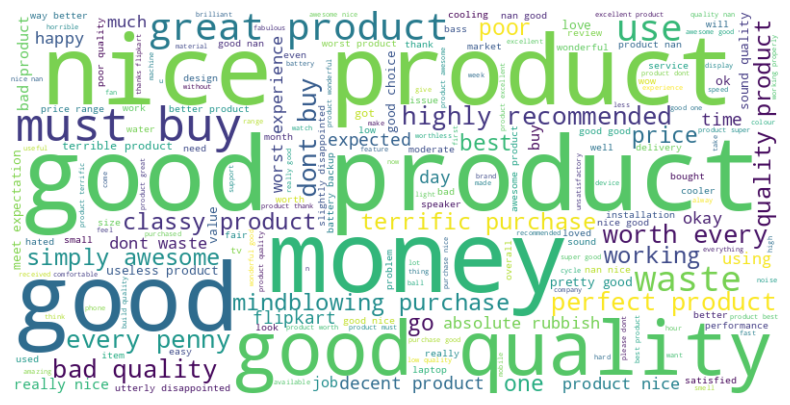

In [10]:
print("Final shape:", df.shape)
print("Missing values:\n", df.isnull().sum())
print("Duplicates:", df.duplicated().sum())
print("Sentiment distribution:\n", df['Sentiment'].value_counts())

text_data = " ".join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


**Exploratory Data Analysis (EDA)**

In [11]:
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nSummary Stats:\n", df.describe(include="all"))

Shape: (144871, 7)

Data Types:
 ProductName      object
ProductPrice    float64
Rate            float64
Review           object
Summary          object
Sentiment        object
text             object
dtype: object

Summary Stats:
                                          ProductName   ProductPrice  \
count                                         144871  144871.000000   
unique                                           908            NaN   
top     lakm eyeconic kajal twin packdeep black 07 g            NaN   
freq                                            3802            NaN   
mean                                             NaN    5237.055194   
std                                              NaN   10958.730023   
min                                              NaN      59.000000   
25%                                              NaN     449.000000   
50%                                              NaN    1529.000000   
75%                                              NaN    44

/tmp/ipython-input-732843528.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


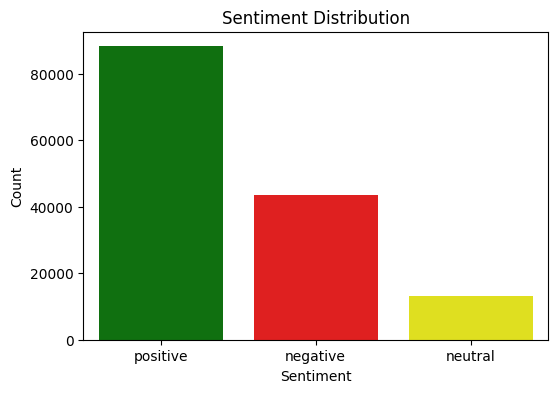

In [12]:
color_map = {"positive": "green", "negative": "red", "neutral": "yellow"}

plt.figure(figsize=(6,4))
sns.countplot(
    x="Sentiment",
    data=df,
    palette=color_map
)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


/tmp/ipython-input-24129186.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


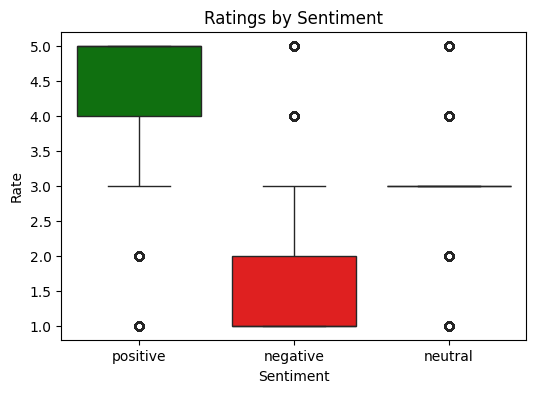

In [13]:
plt.figure(figsize=(6,4))
sns.boxplot(
    x="Sentiment",
    y="Rate",
    data=df,
    palette=color_map
)
plt.title("Ratings by Sentiment")
plt.show()

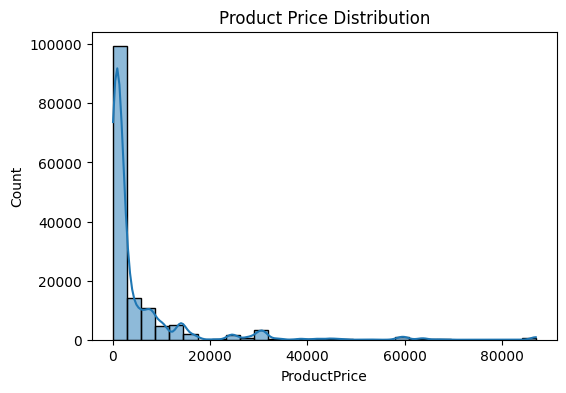

In [14]:
plt.figure(figsize=(6,4))
sns.histplot(df["ProductPrice"], bins=30, kde=True)
plt.title("Product Price Distribution")
plt.show()

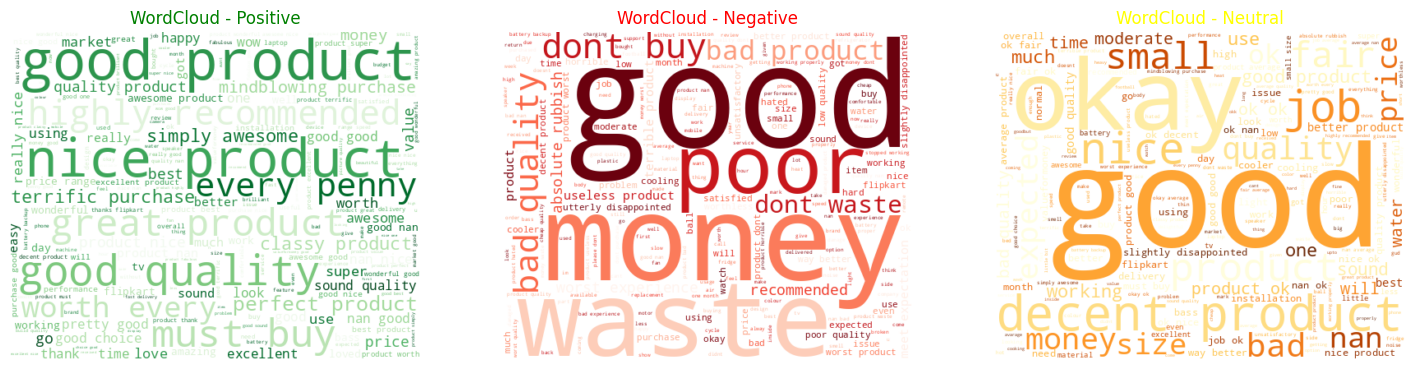

In [15]:
fig, axes = plt.subplots(1,3, figsize=(18,6))

for i, sentiment in enumerate(["positive","negative","neutral"]):
    text_data = " ".join(df[df["Sentiment"]==sentiment]["text"])
    wordcloud = WordCloud(
        width=500, height=400,
        background_color="white",
        colormap="Greens" if sentiment=="positive" else "Reds" if sentiment=="negative" else "YlOrBr"
    ).generate(text_data)
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].set_title(f"WordCloud - {sentiment.capitalize()}", color=color_map[sentiment])
    axes[i].axis("off")

plt.show()


In [16]:
from collections import Counter
from wordcloud import WordCloud

def get_top_words(sentiment, n=10):
    text = " ".join(df[df["Sentiment"]==sentiment]["text"])
    words = text.split()
    common = Counter(words).most_common(n)
    return pd.DataFrame(common, columns=["Word","Frequency"])

print("\nTop Positive Words:\n", get_top_words("positive"))
print("\nTop Negative Words:\n", get_top_words("negative"))
print("\nTop Neutral Words:\n", get_top_words("neutral"))


Top Positive Words:
       Word  Frequency
0     good      46588
1  product      42606
2       is      25821
3      the      23360
4     nice      22904
5     very      22710
6      and      21941
7      for      18287
8       it      18005
9     this      13863

Top Negative Words:
       Word  Frequency
0      not      24143
1  product      18489
2       is      17206
3     very      14543
4      the      12616
5      bad      10636
6       it      10483
7     good      10085
8  quality       9792
9       of       9288

Top Neutral Words:
       Word  Frequency
0       is       4891
1     good       4617
2  product       4230
3      not       4099
4      the       3787
5       ok       2978
6      but       2927
7       it       2077
8     just       1786
9     very       1735


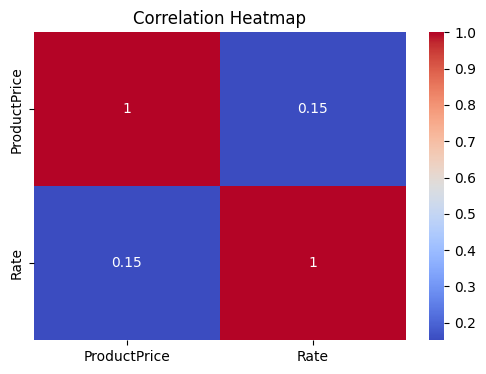

In [17]:
plt.figure(figsize=(6,4))
sns.heatmap(df[["ProductPrice","Rate"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [18]:
sentiment_perc = df['Sentiment'].value_counts(normalize=True) * 100
print("Sentiment % Distribution:\n", sentiment_perc)

Sentiment % Distribution:
 Sentiment
positive    60.904529
negative    29.968041
neutral      9.127431
Name: proportion, dtype: float64


In [19]:
avg_rating = df.groupby("Sentiment")["Rate"].mean()
print("Average Rating per Sentiment:\n", avg_rating)

Average Rating per Sentiment:
 Sentiment
negative    1.561327
neutral     2.988051
positive    4.596523
Name: Rate, dtype: float64


In [20]:
avg_price = df.groupby("Sentiment")["ProductPrice"].mean()
print("Average Price per Sentiment:\n", avg_price)

Average Price per Sentiment:
 Sentiment
negative    3321.211540
neutral     3121.950768
positive    6496.724230
Name: ProductPrice, dtype: float64


/tmp/ipython-input-3257697936.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Sentiment", y="review_length", data=df, palette={"positive":"green","negative":"red","neutral":"yellow"})


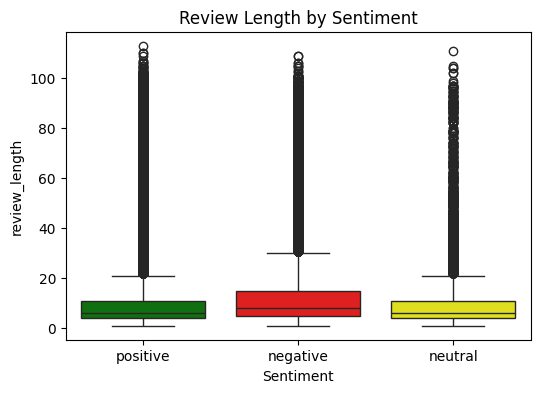

Average Review Length by Sentiment:
 Sentiment
negative    13.573396
neutral     10.011268
positive    11.176510
Name: review_length, dtype: float64


In [21]:
df["review_length"] = df["text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6,4))
sns.boxplot(x="Sentiment", y="review_length", data=df, palette={"positive":"green","negative":"red","neutral":"yellow"})
plt.title("Review Length by Sentiment")
plt.show()

print("Average Review Length by Sentiment:\n", df.groupby("Sentiment")["review_length"].mean())

In [22]:
corr = df[["Rate","review_length"]].corr()
print("Correlation between Rating & Review Length:\n", corr)

Correlation between Rating & Review Length:
                    Rate  review_length
Rate           1.000000      -0.058473
review_length -0.058473       1.000000


/tmp/ipython-input-1283556360.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Sentiment", y="ProductPrice", data=df, palette={"positive":"green","negative":"red","neutral":"yellow"})


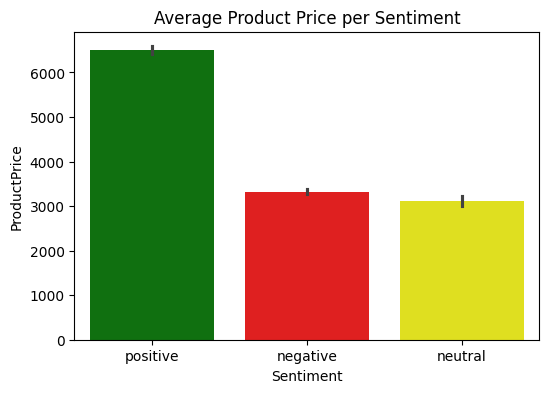

In [23]:
plt.figure(figsize=(6,4))
sns.barplot(x="Sentiment", y="ProductPrice", data=df, palette={"positive":"green","negative":"red","neutral":"yellow"})
plt.title("Average Product Price per Sentiment")
plt.show()

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2,2), stop_words="english", max_features=15)
X2 = vectorizer.fit_transform(df["text"])
bigrams = pd.DataFrame(sorted(zip(vectorizer.get_feature_names_out(), X2.sum(axis=0).tolist()[0]), key=lambda x: -x[1]), columns=["Bigram","Frequency"])
print("Top Bigrams:\n", bigrams)

Top Bigrams:
                   Bigram  Frequency
0           good product       9173
1           nice product       7740
2           product good       6676
3            waste money       5973
4           good quality       5357
5          great product       3834
6     highly recommended       3242
7            worth penny       3219
8        quality product       3216
9            best market       3191
10              dont buy       3191
11       perfect product       3183
12           bad quality       3154
13  mindblowing purchase       3130
14              just wow       3115


In [25]:
product_sentiment = df.groupby("ProductName")["Sentiment"].value_counts(normalize=True).unstack().fillna(0)
product_sentiment.head(10)

Sentiment,negative,neutral,positive
ProductName,,,
288sdtl timewear silver pink dial stainless steel strap analog watch for women,0.069106,0.024390,0.906504
7seven airtel dth remote airtel xstream remote compatible with sd and hd recording compatible for original set top or setup box digital tv remote control airtel set top box airtel xstream android tv set top box remote controllerblack,0.062500,0.062500,0.875000
aced m2 pubg triggers for mobile gaming for bgmifree firecod mobileetc gaming accessory kit black for android ios,1.000000,0.000000,0.000000
acer aspire 3 ryzen 3 dual core 3250u 8 gb256 gb ssdwindows 11 home a31523 laptop 156 inch charcoal black 19 kg,0.750000,0.250000,0.000000
acer aspire 7 core i5 12th gen 16 gb512 gb ssdwindows 11 home4 gb graphicsnvidia geforce gtx 1650 a7155g a71551g gaming laptop 156 inch charcoal black 21 kg,0.679245,0.320755,0.000000
acer aspire 7 ryzen 5 hexa core amd r55500u 8 gb512 gb ssdwindows 11 home4 gb graphicsnvidia geforce gtx 1650 a71542g a71542gr2ne gaming laptop 156 inch black 215 kg,0.696429,0.303571,0.000000
adonai pot15l blue rice cooker food steamer egg boiler travel cooker15 l blue,1.000000,0.000000,0.000000
adonai pot15lpink rice cooker food steamer travel cooker slow cooker electric pressure cooker15 l pink,0.408784,0.148649,0.442568
adonyx combo of kneepalm elbow ankle support,0.163636,0.090909,0.745455


**Feature Engineering**

In [26]:
le = LabelEncoder()
df['SentimentEncoded'] = le.fit_transform(df['Sentiment'])

print("\nSentiment Encoding Mapping:")
for i, cls in enumerate(le.classes_):
    print(f"{cls} -> {i}")


Sentiment Encoding Mapping:
negative -> 0
neutral -> 1
positive -> 2


In [27]:
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X = tfidf.fit_transform(df["text"])
y = df["Sentiment"]

print("Shape of TF-IDF Matrix:", X.shape)


Shape of TF-IDF Matrix: (144871, 5000)


In [28]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_encoded = le.fit_transform(df["Sentiment"])

print("\nSentiment Encoding Mapping:")
for i, cls in enumerate(le.classes_):
    print(f"{cls} -> {i}")

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

print("\nClass distribution before SMOTE:", np.bincount(y_encoded))
print("Class distribution after SMOTE:", np.bincount(y_resampled))

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)

print("\nTrain/Test Shape:")
print("Train:", X_train.shape, " Test:", X_test.shape)



Sentiment Encoding Mapping:
negative -> 0
neutral -> 1
positive -> 2

Class distribution before SMOTE: [43415 13223 88233]
Class distribution after SMOTE: [88233 88233 88233]

Train/Test Shape:
Train: (211759, 5000)  Test: (52940, 5000)


**Model Training & Evaluation**

In [29]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "XGBoost": XGBClassifier(eval_metric="mlogloss", random_state=42)
}

results = {}


 Training: Logistic Regression

Logistic Regression Accuracy: 0.8340

Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.85      0.84     17646
     neutral       0.80      0.76      0.78     17647
    positive       0.86      0.89      0.88     17647

    accuracy                           0.83     52940
   macro avg       0.83      0.83      0.83     52940
weighted avg       0.83      0.83      0.83     52940



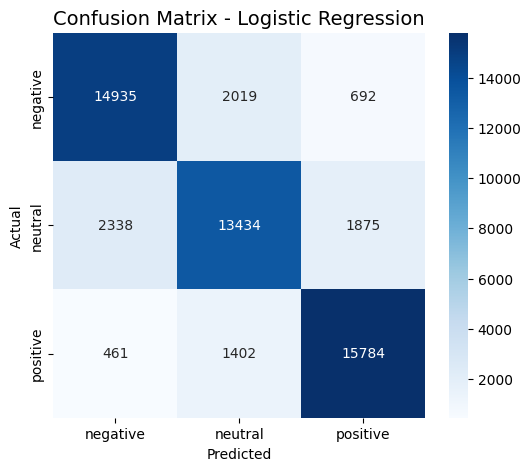


 Training: Random Forest

Random Forest Accuracy: 0.9238

Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.91      0.92     17646
     neutral       0.90      0.93      0.92     17647
    positive       0.93      0.94      0.93     17647

    accuracy                           0.92     52940
   macro avg       0.92      0.92      0.92     52940
weighted avg       0.92      0.92      0.92     52940



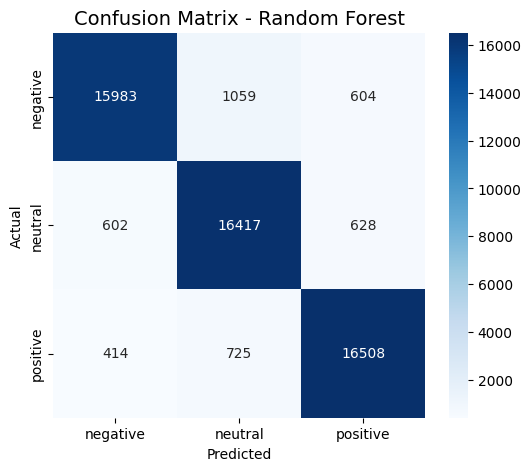


 Training: Naive Bayes

Naive Bayes Accuracy: 0.8115

Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.84      0.82     17646
     neutral       0.79      0.70      0.74     17647
    positive       0.83      0.90      0.86     17647

    accuracy                           0.81     52940
   macro avg       0.81      0.81      0.81     52940
weighted avg       0.81      0.81      0.81     52940



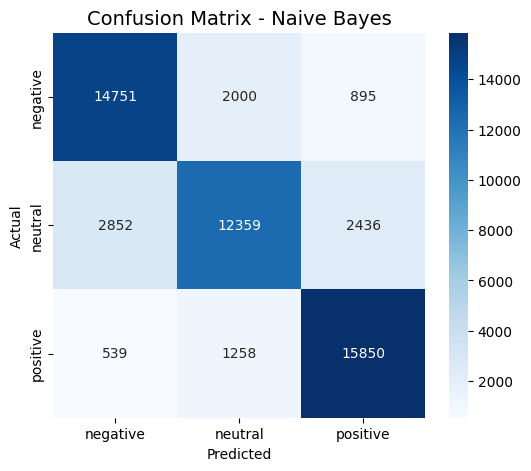


 Training: XGBoost

XGBoost Accuracy: 0.8440

Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.84      0.85     17646
     neutral       0.82      0.77      0.79     17647
    positive       0.85      0.92      0.89     17647

    accuracy                           0.84     52940
   macro avg       0.84      0.84      0.84     52940
weighted avg       0.84      0.84      0.84     52940



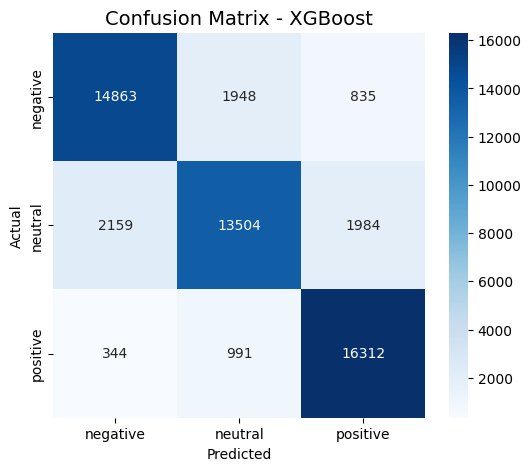

In [30]:
for name, model in models.items():
    print("\n" + "="*60)
    print(f" Training: {name}")
    print("="*60)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"\n{name} Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=le.classes_, yticklabels=le.classes_
    )
    plt.title(f"Confusion Matrix - {name}", fontsize=14)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [31]:
print("\nModel Performance Summary:")
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.4f}")


Model Performance Summary:
Logistic Regression: 0.8340
Random Forest: 0.9238
Naive Bayes: 0.8115
XGBoost: 0.8440


Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Hyperparameters found:
{'subsample': 0.7, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.7}

Best CV Score (F1 Macro): 0.8725114396499533

Tuned XGBoost Accuracy: 0.8763128069512656

Classification Report (Tuned XGBoost):
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88     17646
     neutral       0.86      0.83      0.84     17647
    positive       0.88      0.93      0.91     17647

    accuracy                           0.88     52940
   macro avg       0.88      0.88      0.88     52940
weighted avg       0.88      0.88      0.88     52940



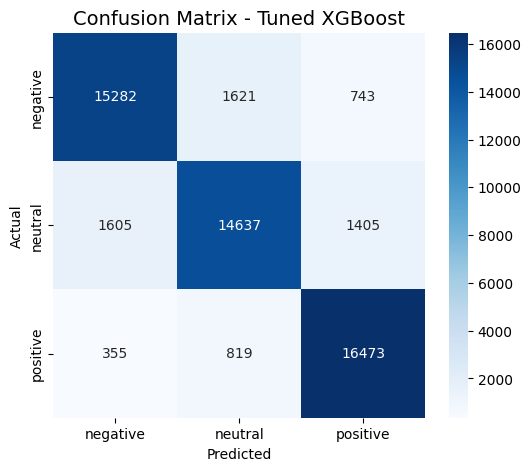

In [32]:
from sklearn.model_selection import RandomizedSearchCV

xgb_params = {
    "n_estimators": [300, 500],
    "max_depth": [4, 6, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

xgb_clf = XGBClassifier(eval_metric="mlogloss", random_state=42)

random_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=xgb_params,
    scoring="f1_macro",
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_xgb.fit(X_train, y_train)

print("\nBest Hyperparameters found:")
print(random_xgb.best_params_)

print("\nBest CV Score (F1 Macro):", random_xgb.best_score_)

best_xgb = random_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("\nTuned XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report (Tuned XGBoost):")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Tuned XGBoost", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



Top 20 Features Driving Sentiment Predictions:


,Feature,Importance
0,meet,0.009007
1,worst,0.007651
2,waste,0.005539
3,amazing,0.005189
4,poor,0.005066
5,ok,0.005054
6,rubbish,0.004991
7,excellent,0.004483
8,love,0.004421
9,avarage,0.004373


/tmp/ipython-input-2136916047.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


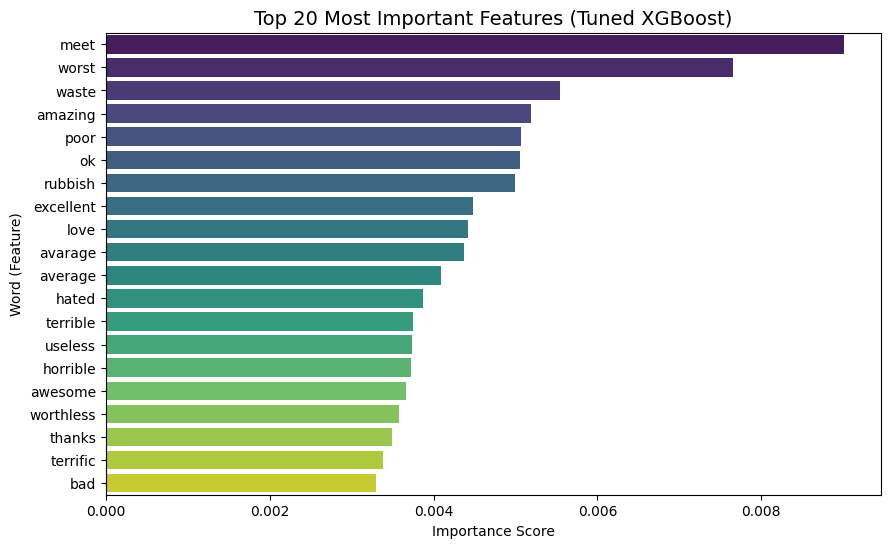

In [33]:
feature_names = np.array(tfidf.get_feature_names_out())
importances = best_xgb.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

top_n = 20
feature_importance_df = pd.DataFrame({
    "Feature": feature_names[sorted_idx[:top_n]],
    "Importance": importances[sorted_idx[:top_n]]
})

print(f"\nTop {top_n} Features Driving Sentiment Predictions:")
display(feature_importance_df)

plt.figure(figsize=(10,6))
sns.barplot(
    data=feature_importance_df,
    x="Importance", y="Feature", palette="viridis"
)
plt.title(f"Top {top_n} Most Important Features (Tuned XGBoost)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Word (Feature)")
plt.show()


In [34]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(best_xgb, X_resampled, y_resampled,
                            cv=cv, scoring="f1_macro", n_jobs=-1)

print("Cross-Validation Scores (F1 Macro):", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))
print("Std Deviation:", np.std(cv_scores))


Cross-Validation Scores (F1 Macro): [0.8761166  0.87726165 0.87749806 0.87525268 0.87788677]
Mean CV Score: 0.8768031518571512
Std Deviation: 0.0009739261601702678


In [35]:
import joblib

joblib.dump(best_xgb, "sentiment_xgb_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

loaded_model = joblib.load("sentiment_xgb_model.pkl")
loaded_vectorizer = joblib.load("tfidf_vectorizer.pkl")

sample_review = ["This product is absolutely fantastic, I love it!"]
sample_transformed = loaded_vectorizer.transform(sample_review)
prediction = loaded_model.predict(sample_transformed)

print("Sample Review:", sample_review[0])
print("Predicted Sentiment:", le.inverse_transform(prediction)[0])


Sample Review: This product is absolutely fantastic, I love it!
Predicted Sentiment: positive


In [36]:
!zip -r /content/sample_data.zip /content/sample_data
from google.colab import files
files.download('/content/sample_data.zip')

  adding: content/sample_data/ (stored 0%)
  adding: content/sample_data/anscombe.json (deflated 83%)
  adding: content/sample_data/README.md (deflated 39%)
  adding: content/sample_data/california_housing_train.csv (deflated 79%)
  adding: content/sample_data/mnist_test.csv (deflated 88%)
  adding: content/sample_data/mnist_train_small.csv (deflated 88%)
  adding: content/sample_data/california_housing_test.csv (deflated 76%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>